<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Используемые-библиотеки" data-toc-modified-id="Используемые-библиотеки-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Используемые библиотеки</a></span></li><li><span><a href="#Конфиг-подключения-к-Авроре" data-toc-modified-id="Конфиг-подключения-к-Авроре-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Конфиг подключения к Авроре</a></span></li><li><span><a href="#Загружаем-и-подготавливаем-полигон-для-построения-графа-внутри-него" data-toc-modified-id="Загружаем-и-подготавливаем-полигон-для-построения-графа-внутри-него-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Загружаем и подготавливаем полигон для построения графа внутри него</a></span></li><li><span><a href="#Функция-для-тестирования-разных-параметров-выгрузки-графа" data-toc-modified-id="Функция-для-тестирования-разных-параметров-выгрузки-графа-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Функция для тестирования разных параметров выгрузки графа</a></span></li><li><span><a href="#Загружаем-граф-с-разными-тегами-osm" data-toc-modified-id="Загружаем-граф-с-разными-тегами-osm-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Загружаем граф с разными тегами osm</a></span></li><li><span><a href="#Чистим-граф" data-toc-modified-id="Чистим-граф-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чистим граф</a></span><ul class="toc-item"><li><span><a href="#Убираем-дублирование-вершин-графа" data-toc-modified-id="Убираем-дублирование-вершин-графа-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Убираем дублирование вершин графа</a></span></li><li><span><a href="#Убираем-пропуски-в-линиях,-соединениях-и-ложных-вершинах" data-toc-modified-id="Убираем-пропуски-в-линиях,-соединениях-и-ложных-вершинах-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Убираем пропуски в линиях, соединениях и ложных вершинах</a></span></li></ul></li><li><span><a href="#Сохраняем-граф" data-toc-modified-id="Сохраняем-граф-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Сохраняем граф</a></span></li><li><span><a href="#Команда-для-конвертации-в-формат-pbf-через-osmosis" data-toc-modified-id="Команда-для-конвертации-в-формат-pbf-через-osmosis-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Команда для конвертации в формат pbf через osmosis</a></span></li><li><span><a href="#Строим-самокатный-маршрут" data-toc-modified-id="Строим-самокатный-маршрут-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Строим самокатный маршрут</a></span></li></ul></div>

## Используемые библиотеки

In [1]:
import h3
import geopandas as gpd
import folium
import pandas as pd
from sqlalchemy import create_engine
import os
from shapely.geometry import Polygon, Point, MultiLineString, LineString
from functools import reduce
import momepy
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
ox.config(use_cache=True, log_console=True)
from sklearn.neighbors import KDTree 
ox.__version__
pd.set_option('display.max_columns', None)

/var/folders/1h/3k869hdj4494vj7b2jn7nxfm0000gn/T/ipykernel_47084/1225454180.py:13: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


## Конфиг подключения к Авроре

In [2]:
driver = 'postgresql+psycopg2://'
user = 'georgy_ovnanyan'
password = ''
hostname = 'whoosh-prod-aurora.cluster-cqlsvpdknncb.eu-west-1.rds.amazonaws.com:5432'
db_name = 'db-whoosh'
engine = create_engine('{driver}{user}:{password}@{hostname}/{db_name}'.format(
                                                                                driver = driver,
                                                                                user = user,
                                                                                password = password,
                                                                                hostname = hostname,
                                                                                db_name = db_name)
)

## Загружаем и подготавливаем полигон для построения графа внутри него

Полигон нужен для того, чтобы потом скачивать граф только по нашим зонам проката

In [25]:
area = gpd.GeoDataFrame.from_postgis('''
                                        select id, name, borders_geom
                                        from public.area
                                        where region_id in (7, 30)
                                              and status = 'ACTIVE' 
                                              and "type" = 'LIMITED'                                              
                                     ''', con=engine, 
                                          geom_col='borders_geom', 
                                          crs='4326')
area.explore()

In [26]:
area.head()

,id,name,borders_geom
0,104,Новосибирск - Город,"POLYGON ((82.87160 55.05146, 82.87377 55.05210..."
1,31,Academ main limited,"POLYGON ((83.09437 54.87135, 83.09355 54.87103..."


In [27]:
area = area.dissolve()
area.explore()

In [28]:
area.head()

,borders_geom,id,name
0,"MULTIPOLYGON (((83.09355 54.87103, 83.09454 54...",104,Новосибирск - Город


In [12]:
# and name = 'Москва  '

## Функция для тестирования разных параметров выгрузки графа

In [29]:
def get_graph(filter_1, filter_2):
    
    # получаем граф
    G1 = ox.graph_from_polygon(
                            area.geometry[0],
                            retain_all = True,
                            network_type = 'all',
                            simplify = False,
                            truncate_by_edge = True,
                            custom_filter = my_filter_1
    )
    try:
        G2 = ox.graph_from_polygon(
                                area.geometry[0],
                                retain_all = True,
                                network_type = 'all',
                                simplify = False,
                                truncate_by_edge = True,
                                custom_filter = my_filter_2
        )

        G = nx.compose(G1, G2)
        
        print(len(G1), len(G2), len(G))
    
    except:
        G = G1.copy()
        
        print(len(G))
    
    
    
    # рисуем граф
    ox.plot_graph(G, figsize=(20,20));
    
    return G

## Загружаем граф с разными тегами osm 

81230


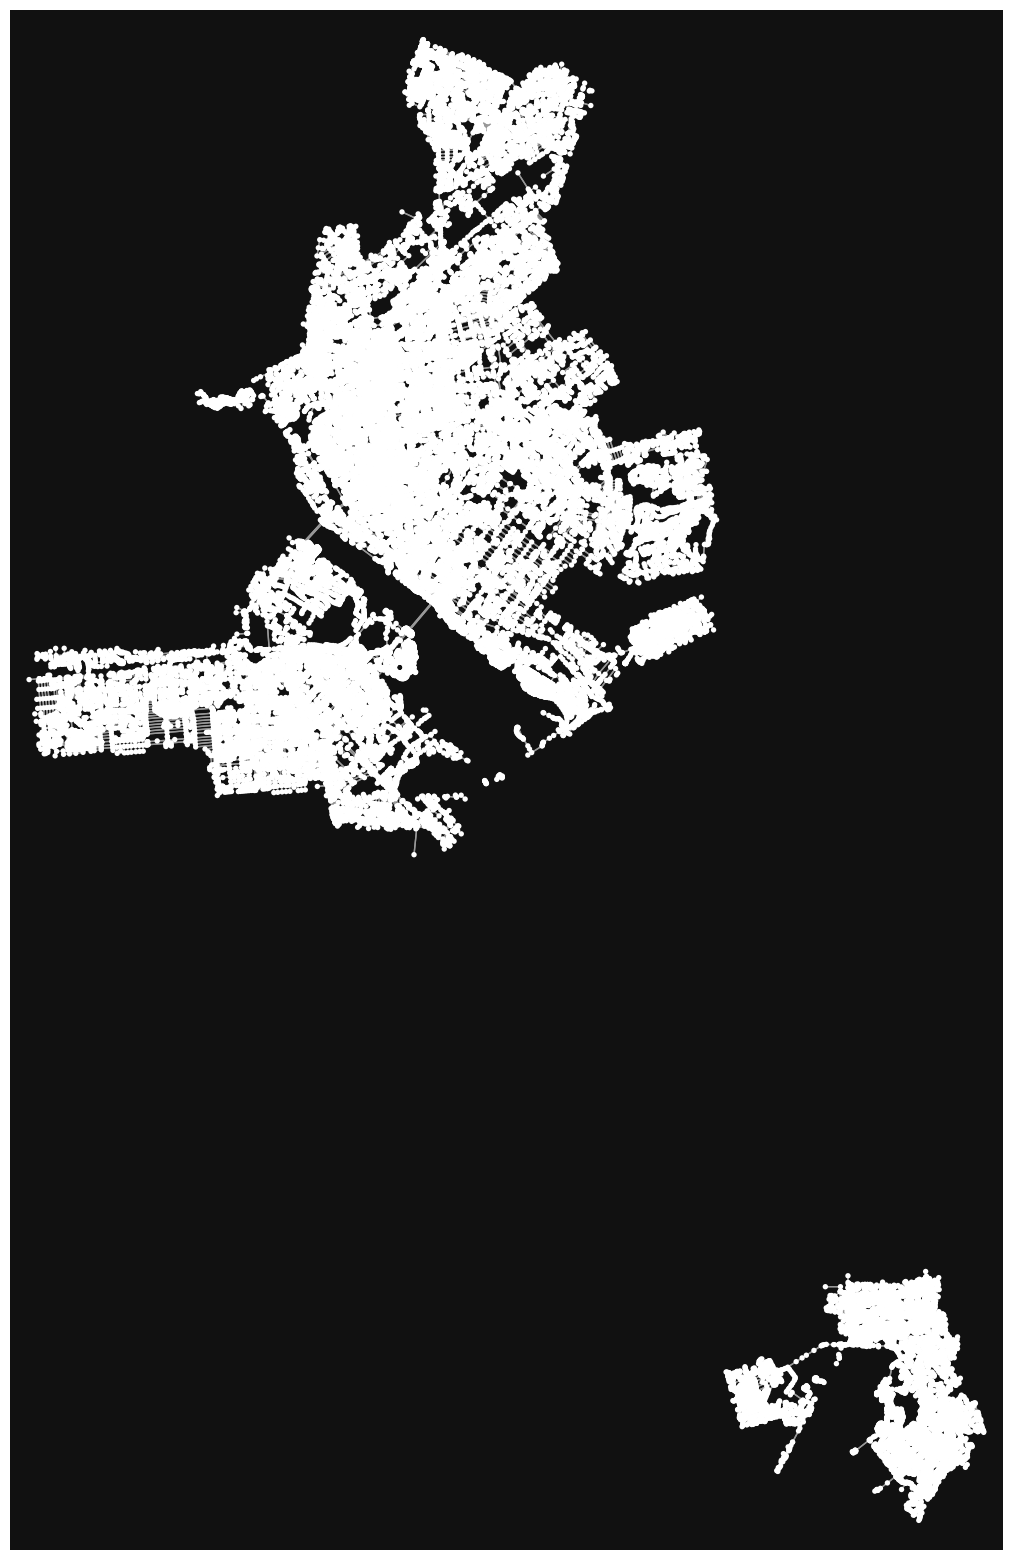

CPU times: user 13.5 s, sys: 303 ms, total: 13.8 s
Wall time: 15.3 s


In [30]:
%%time
my_filter_1 = '["highway"~"unclassified|steps|cycleway|footway|pedestrian|footwalk|residential|living_street|service|platform|crossing"]["cycleway"!~"share_busway|shared_lane"]'
my_filter_2 = '["railway"~"crossing"]'

G = get_graph(my_filter_1, my_filter_2)

## Чистим граф

### Убираем дублирование вершин графа

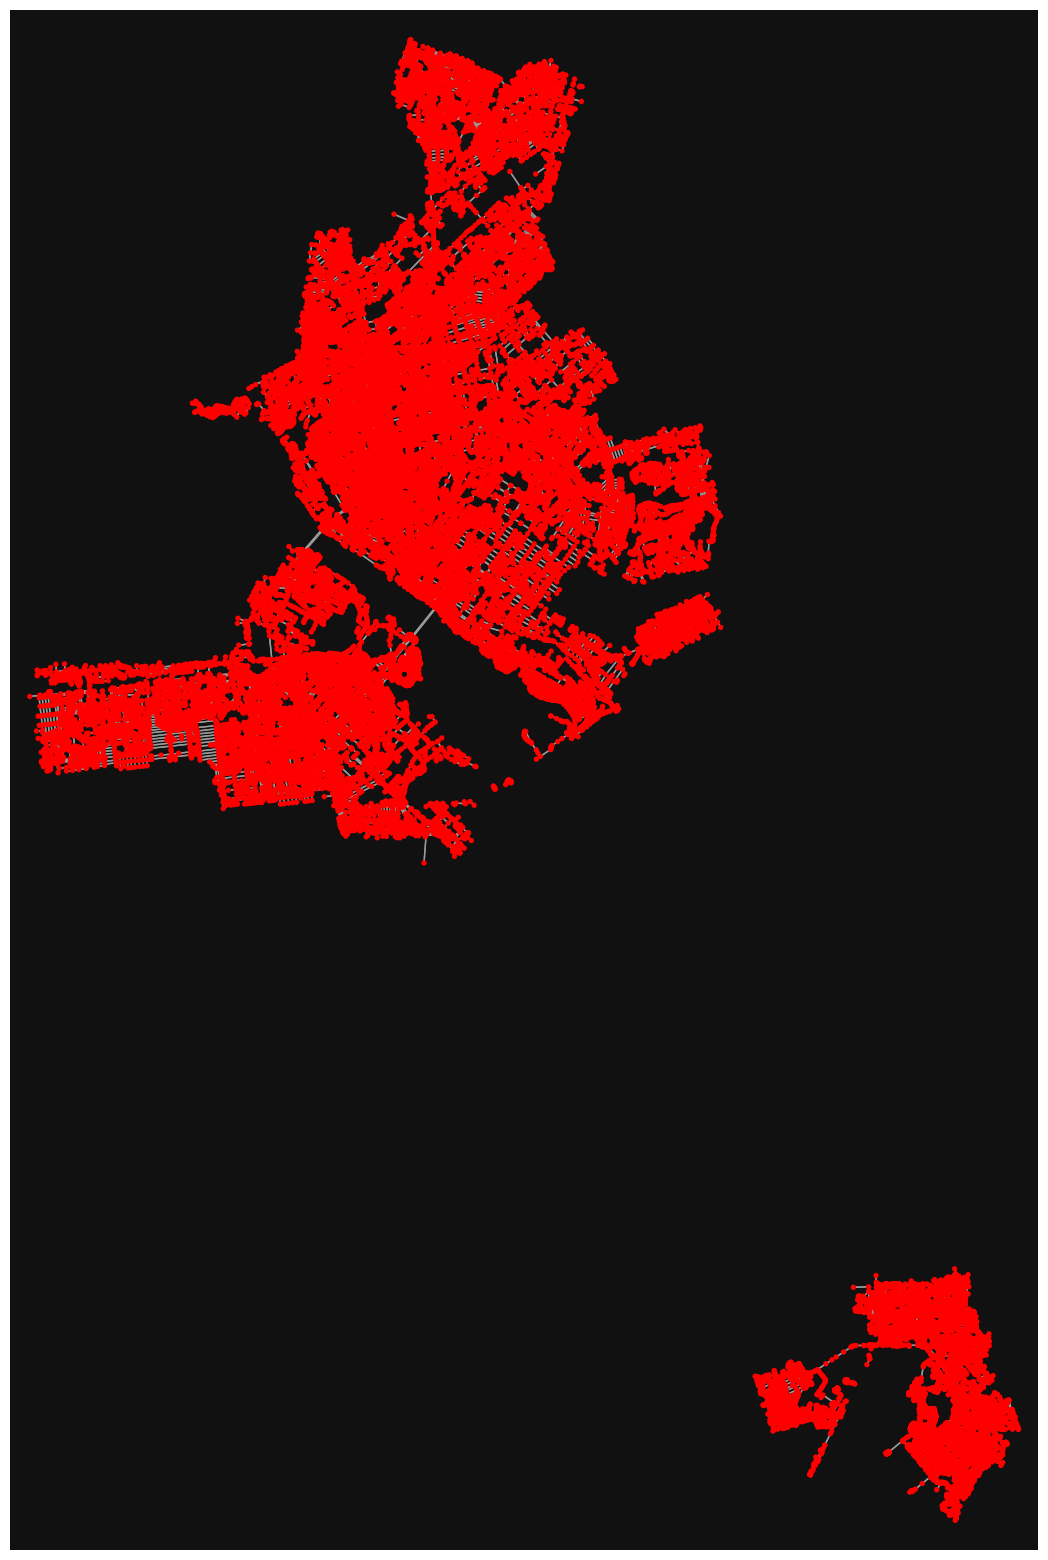

CPU times: user 34.1 s, sys: 1.16 s, total: 35.3 s
Wall time: 34.9 s


In [31]:
%%time
# устанавливаем проекцию в соответствии с городом
G = ox.project_graph(G)

# убираем дублирование вершин графа
G = ox.consolidate_intersections(G, tolerance=1, rebuild_graph=True, dead_ends=True)

ox.plot_graph(G, figsize=(20,20), node_color='r');

# устанавливаем проекцию обратно в 4326 для графхоппера
G = ox.project_graph(G, to_crs='4326')

### Убираем пропуски в линиях, соединениях и ложных вершинах

In [ ]:
%%time
# получаем вершины графа
# gdf_nodes = ox.graph_to_gdfs(
#                                 G,
#                                 nodes=True, 
#                                 edges=False,
#                                 node_geometry=True 
#                                )

# поулчаем ребра графа
# gdf_edges = ox.graph_to_gdfs(
#                                 G,
#                                 nodes=False, 
#                                 edges=True,
#                                 node_geometry=False, 
#                                 fill_edge_geometry=True
#                                ).reset_index()

# удаляем ложные вершины c помощью momepy
# gdf_edges = momepy.remove_false_nodes(gdf_edges)

# удаляем разрывы между примыканиями ребр
# gdf_edges = momepy.extend_lines(gdf_edges, tolerance=5)

# удаляем разрывы в ребрах 
# gdf_edges.geometry = momepy.close_gaps(gdf_edges, tolerance=10)

# конвертируем геодатафрейм обратно в граф
# gdf_edges = gdf_edges.dropna(subset=['u','v','key']).reset_index(drop=True)
# gdf_edges[['u','v','key']] = gdf_edges[['u','v','key']].astype('int')
# gdf_edges = gdf_edges.set_index(['u','v','key'])
# G = ox.graph_from_gdfs(gdf_nodes, gdf_edges)

# устанавливаем проекцию обратно в 4326 для графхоппера
# G = ox.project_graph(G, to_crs='4326')

# ox.plot_graph(G, figsize=(20,20), node_color='r')

## Сохраняем граф 

In [32]:
%%time
ox.save_graph_xml(G, filepath='./data/test/Novosibirsk_graph.osm')

/Users/georgy/anaconda3/lib/python3.11/site-packages/osmnx/io.py:361: UserWarning: For the `save_graph_xml` function to behave properly, the graph must have been created with `ox.settings.all_oneway=True`.
  osm_xml._save_graph_xml(


CPU times: user 1min 21s, sys: 1.84 s, total: 1min 23s
Wall time: 1min 22s


## Команда для конвертации в формат pbf через osmosis

osmosis --read-xml file=Novosibirsk_graph.osm --write-pbf Novosibirsk_graph.osm.pbf

## Строим самокатный маршрут 

In [ ]:
tree = KDTree(gdf_nodes[['y', 'x']], metric='euclidean')

In [ ]:
def node_list_to_coordinate_lines(G, node_list, use_geom=True):
    """
    Given a list of nodes, return a list of lines that together follow the path
    defined by the list of nodes.

    Parameters
    ----------
    G : networkx multidigraph
    route : list
        the route as a list of nodes
    use_geom : bool
        if True, use the spatial geometry attribute of the edges to draw
        geographically accurate edges, rather than just lines straight from node
        to node

    Returns
    -------
    lines : list of lines given as pairs ( (x_start, y_start), (x_stop, y_stop) )
    """
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    for u, v in edge_nodes:
        # if there are parallel edges, select the shortest in length
        data = min(G.get_edge_data(u, v).values(), key=lambda x: x['length'])

        # if it has a geometry attribute (ie, a list of line segments)
        if 'geometry' in data and use_geom:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute, the edge is a straight
            # line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
    return lines

In [ ]:
# функция для поиска ближайшей ноды к заданной точке
def find_nearest_node(tree, gdf, point):
    closest_idx = tree.query([(point.y, point.x)], k=1, return_distance=False)[0]
    nearest_node = gdf.iloc[closest_idx].index.values[0]
    return nearest_node

In [ ]:
# построение маршрута
def osmnx_route(x1,y1,x2,y2):
    node_1 = find_nearest_node(tree, gdf_nodes, Point(x1,y1))
    node_2 = find_nearest_node(tree, gdf_nodes, Point(x2,y2))
    route = ox.shortest_path(G, node_1, node_2, weight='length', cpus=1)
    
    fig, ax = ox.plot_graph_route(G,
                                  route,
                                  show=False,
                                  close=False,
                                  route_color='green',
                                  figsize=(20,20)
                                 )
    plt.show()
    
    m = ox.plot_route_folium(G, 
                             route, 
                             route_color='red', 
                             roude_opacity=0.7, 
                             roude_width=3)
    
    route = node_list_to_coordinate_lines(G, route)
    return MultiLineString(route), m

In [ ]:
route, m = osmnx_route(37.547632,55.746453,37.551084,55.751348)
m

In [ ]:
# допом считаем длину маршрута
route_graph = gpd.GeoDataFrame({'geometry' : [route]}, geometry='geometry', crs={'init':'epsg:4326'})
route_graph = route_graph.to_crs(epsg=32637)
route_graph['len'] = route_graph['geometry'].length
route_graph